In [ ]:
import os

In [ ]:
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.utils import class_weight

### xgb

In [ ]:
# Load data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# Preprocess text data using CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X = vectorizer.fit_transform(train_df['text'])
y = train_df['label']
X_test = vectorizer.transform(test_df['text'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Convert the data types of the features to float64
print("Converting data types to float64...")
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)


# Define class weights to handle imbalanced classes
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Train XGBoost model using RandomizedSearchCV to find optimal hyperparameters
xgb_model = xgb.XGBClassifier(objective='multi:softmax', 
                              num_class=8, 
                              n_jobs=-1)

params = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_lambda': [0, 1, 10],
    'gamma': [0, 1, 10]
}

xgb_search = RandomizedSearchCV(xgb_model, params, cv=5, 
                                scoring='f1_macro', n_iter=20, 
                                random_state=42, n_jobs=-1, verbose=10)

xgb_search.fit(X_train, y_train, sample_weight=classes_weights,verbose=2)

# Evaluate on validation set and make predictions on test set
val_pred = xgb_search.predict(X_val)
test_pred = xgb_search.predict(X_test)

# Calculate macro f1 score on validation set
val_f1 = f1_score(y_val, val_pred, average='macro')
print(f'Validation F1 score: {val_f1:.4f}')

# Save predictions to submission file
# submission_df = pd.DataFrame({'id': test_df['id'], 'label': test_pred})
# submission_df.to_csv('sample_submission.csv', index=False)

In [ ]:
xgb_search.best_estimator_

# best1

In [ ]:
# Load the training data
print("Loading training data...")
train_df = pd.read_csv('./data/train.csv')

# Preprocess the text data by converting it to lowercase using CountVectorizer
print("Preprocessing text data...")
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(train_df['text'])
y = train_df['label']

# Split the data into training and validation sets
print("Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Convert the data types of the features to float64
print("Converting data types to float64...")
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)

# Calculate class weights to handle imbalanced data
print("Calculating class weights...")
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Train an XGBoost model on the training set
print("Training XGBoost model...")
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_classes=8, max_depth=6, learning_rate=0.5, n_estimators=150, random_state=42)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', max_depth=6, learning_rate=0.5, n_estimators=150, random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, eval_metric='mlogloss', sample_weight=classes_weights, verbose=True)

# Make predictions on the validation set
print("Making predictions on the validation set...")
y_pred = xgb_model.predict(X_val)

# Evaluate the model using the macro f1 score
print("Evaluating the model...")
f1 = f1_score(y_val, y_pred, average='macro')
print('Macro F1 score:', f1)

# Load the test data
print("Loading test data...")
test_df = pd.read_csv('./data/test.csv')

# Preprocess the text data using CountVectorizer
print("Preprocessing test text data...")
X_test = vectorizer.transform(test_df['text'])
X_test = X_test.astype(np.float64)

# Make predictions on the test set
print("Making predictions on the test set...")
test_pred = xgb_model.predict(X_test)

# Save the predictions to a submission file
print("Saving predictions to submission file...")
# submission_df = pd.DataFrame({'id': test_df['id'], 'label': test_pred})
# submission_df.to_csv('./data/sample_submission_xgb_class_weight_lower.csv', index=False)

### voting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from sklearn.utils import class_weight

# load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

# preprocess the text data using CountVectorizer
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X_train = vectorizer.fit_transform(train_df['text'])
y_train = train_df['label']

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# set class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

# train the models
svc_model = LinearSVC(C=0.1, penalty='l2', class_weight=class_weights, verbose=1)
svc_model.fit(X_train, y_train)

logistic_model = LogisticRegression(C=10, penalty='l2', class_weight=class_weights, verbose=1)
logistic_model.fit(X_train, y_train)

sample_weights = class_weight.compute_sample_weight('balanced', y_train)
xgb_model = XGBClassifier(max_depth=6, learning_rate=0.5, n_estimators=150, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=1)

# create the ensemble model
estimators = [('svc', svc_model), ('logistic', logistic_model), ('xgb', xgb_model)]
voting_model = VotingClassifier(estimators=estimators, voting='hard')

# fit the ensemble model on the training data
voting_model.fit(X_train, y_train)

# evaluate the model on the validation set
y_pred = voting_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
X_test = vectorizer.transform(test_df['text'])
y_test_pred = voting_model.predict(X_test)

# save the predictions to a CSV file
submission_df['label'] = y_test_pred.astype(np.int64)
submission_df.to_csv('submission.csv', index=False)

### boosting

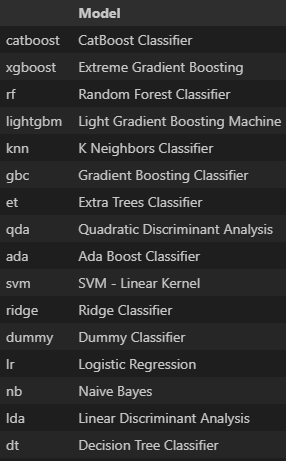

#### TfidfVectorizer and final_xgb

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score
from sklearn.utils import class_weight

# load the data
print("load the data...")
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/sample_submission.csv')

# preprocess the text data using CountVectorizer
print("preprocess the text data using CountVectorizer...")
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X_train = vectorizer.fit_transform(train_df['text'])
y_train = train_df['label']

# split the data into training and validation sets
print("split the data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# set class weights to handle class imbalance
print("set class weights to handle class imbalance...")

class_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

svc_logi_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes= np.unique(y_train),
    y=y_train
)

# train the models
print("train the models...")
svc_model = LinearSVC(C=0.1, penalty='l2',class_weight=dict(zip(np.unique(y_train), svc_logi_class_weights)), verbose=1)
svc_model.fit(X_train, y_train)

logistic_model = LogisticRegression(C=10, penalty='l2', class_weight=dict(zip(np.unique(y_train), svc_logi_class_weights)), verbose=1)
logistic_model.fit(X_train, y_train)

xgb_model = XGBClassifier(max_depth=6, learning_rate=0.5, n_estimators=150, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train, sample_weight=class_weights, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=1)

# create the ensemble model
print("create the ensemble model...")
estimators = [('svc', svc_model), ('logistic', logistic_model), ('xgb', xgb_model)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
submission_df['label'] = y_test_pred.astype(np.int64)
submission_df.to_csv('./data/submission_stacking_final_xgb_tfidf.csv', index=False)

#### parameter input

In [ ]:
# param_grid = {
#     'learning_rate': [0.1, 0.3, 0.5],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [50, 100, 150]
# }

In [ ]:
stacking_model = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=50))

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
submission_df['label'] = y_test_pred.astype(np.int64)
submission_df.to_csv('./data/submission_stacking_final_xgb.csv', index=False)

In [ ]:
stacking_model = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=50))

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
submission_df['label'] = y_test_pred.astype(np.int64)
submission_df.to_csv('./data/submission_stacking_final_xgb.csv', index=False)

#### final - LinearSVC

In [ ]:
### ------------------------------------------------------------------------------------
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LinearSVC())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
# submission_df['label'] = y_test_pred.astype(np.int64)
# submission_df.to_csv('./data/submission_stacking_final_svm.csv', index=False)

#### final - CatBoostClassifier

In [ ]:
from catboost import CatBoostClassifier

### ------------------------------------------------------------------------------------
stacking_model = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
# submission_df['label'] = y_test_pred.astype(np.int64)
# submission_df.to_csv('./data/submission_stacking_final_svm.csv', index=False)

#### final - RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### ------------------------------------------------------------------------------------
stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
# submission_df['label'] = y_test_pred.astype(np.int64)
# submission_df.to_csv('./data/submission_stacking_final_svm.csv', index=False)

#### final - lgbm

In [ ]:
from lightgbm import LGBMClassifier

### ------------------------------------------------------------------------------------
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
# submission_df['label'] = y_test_pred.astype(np.int64)
# submission_df.to_csv('./data/submission_stacking_final_svm.csv', index=False)

#### final - knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

### ------------------------------------------------------------------------------------
stacking_model = StackingClassifier(estimators=estimators, final_estimator=KNeighborsClassifier())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
# submission_df['label'] = y_test_pred.astype(np.int64)
# submission_df.to_csv('./data/submission_stacking_final_svm.csv', index=False)

#### final - gbc

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

### ------------------------------------------------------------------------------------
stacking_model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
# submission_df['label'] = y_test_pred.astype(np.int64)
# submission_df.to_csv('./data/submission_stacking_final_svm.csv', index=False)

#### final - ada

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

### ------------------------------------------------------------------------------------
stacking_model = StackingClassifier(estimators=estimators, final_estimator=AdaBoostClassifier())

# fit the ensemble model on the training data
print("fit the ensemble model on the training data...")
stacking_model.fit(X_train, y_train)

# evaluate the model on the validation set
print("evaluate the model on the validation set...")
y_pred = stacking_model.predict(X_val)
f1_macro = f1_score(y_val, y_pred, average='macro')
print('Validation F1-score (macro):', f1_macro)

# make predictions on the test data
print("make predictions on the test data...")
X_test = vectorizer.transform(test_df['text'])
y_test_pred = stacking_model.predict(X_test)

# save the predictions to a CSV file
print("save the predictions to a CSV file...")
# submission_df['label'] = y_test_pred.astype(np.int64)
# submission_df.to_csv('./data/submission_stacking_final_svm.csv', index=False)

### xgboost

In [ ]:
predictions = [k[0] for k in y_pred]
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
submission_df.to_csv('./data/submission_catb_tuned.csv', index=False)

# Evaluate model on validation set
y_val_pred = grid_search.predict(val_feature)
f1 = f1_score(val_label, y_val_pred, average='macro')
print("Validation F1 score:", f1)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb

# Load the training data
train_data = pd.read_csv("./data/train.csv")

# Preprocess the text data using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(train_data["text"]).astype('float64')
y = train_data["label"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgboost_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, objective='multi:softmax', num_class=8)
xgboost_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='merror', verbose=10)

# Load the test data and preprocess using the same vectorizer
test_data = pd.read_csv("./data/test.csv")
X_test = vectorizer.transform(test_data["text"]).astype('float64')

# Make predictions on the test data and save to submission file
test_data["label"] = xgboost_model.predict(X_test)
test_data[["id", "label"]].to_csv("./data/submission_first.csv", index=False)

# best1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import xgboost as xgb
from sklearn.metrics import f1_score

# Load the training data
print("Loading training data...")
train_df = pd.read_csv('./data/train.csv')

# Preprocess the text data by converting it to lowercase using CountVectorizer
print("Preprocessing text data...")
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(train_df['text'])
y = train_df['label']

# Split the data into training and validation sets
print("Splitting data into training and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Convert the data types of the features to float64
print("Converting data types to float64...")
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)

# Calculate class weights to handle imbalanced data
print("Calculating class weights...")
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Train an XGBoost model on the training set
print("Training XGBoost model...")
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_classes=8, max_depth=6, learning_rate=0.5, n_estimators=150, random_state=42)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', max_depth=6, learning_rate=0.5, n_estimators=150, random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, eval_metric='mlogloss', sample_weight=classes_weights, verbose=True)

# Make predictions on the validation set
print("Making predictions on the validation set...")
y_pred = xgb_model.predict(X_val)

# Evaluate the model using the macro f1 score
print("Evaluating the model...")
f1 = f1_score(y_val, y_pred, average='macro')
print('Macro F1 score:', f1)

# Load the test data
print("Loading test data...")
test_df = pd.read_csv('./data/test.csv')

# Preprocess the text data using CountVectorizer
print("Preprocessing test text data...")
X_test = vectorizer.transform(test_df['text'])
X_test = X_test.astype(np.float64)

# Make predictions on the test set
print("Making predictions on the test set...")
test_pred = xgb_model.predict(X_test)

# Save the predictions to a submission file
print("Saving predictions to submission file...")
submission_df = pd.DataFrame({'id': test_df['id'], 'label': test_pred})
submission_df.to_csv('./data/sample_submission_xgb_class_weight_lower.csv', index=False)